Text(0.5, 1.0, 'Frequency of different subjects in online programs')

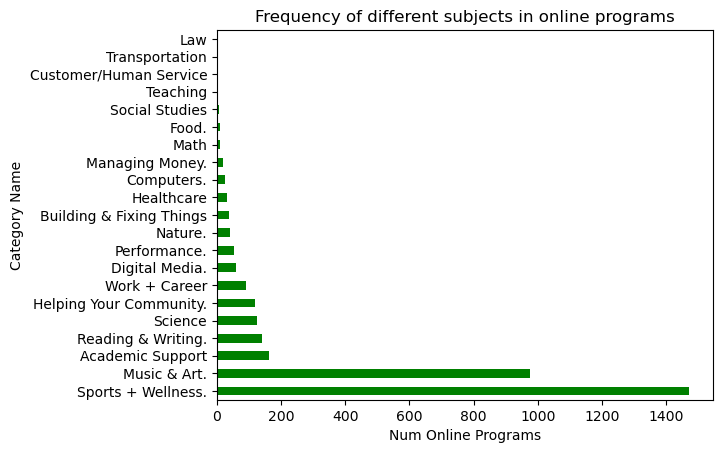

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
my_chi = pd.read_csv('/Users/danielqian/Downloads/My_CHI._My_Future._Programs.csv')
online = my_chi[my_chi['Meeting Type'] == 'online']
online_programs = online[online['Tag'] == 'Program']
online_events = online[online['Tag'] == 'Event']
# online longer-term programs
subject_counts_op = online_programs['Category Name'].value_counts()
subject_counts_op.plot(kind='barh', color='green')
plt.xlabel('Num Online Programs')
plt.title('Frequency of different subjects in online programs')


Text(0.5, 1.0, 'Online programs by subject')

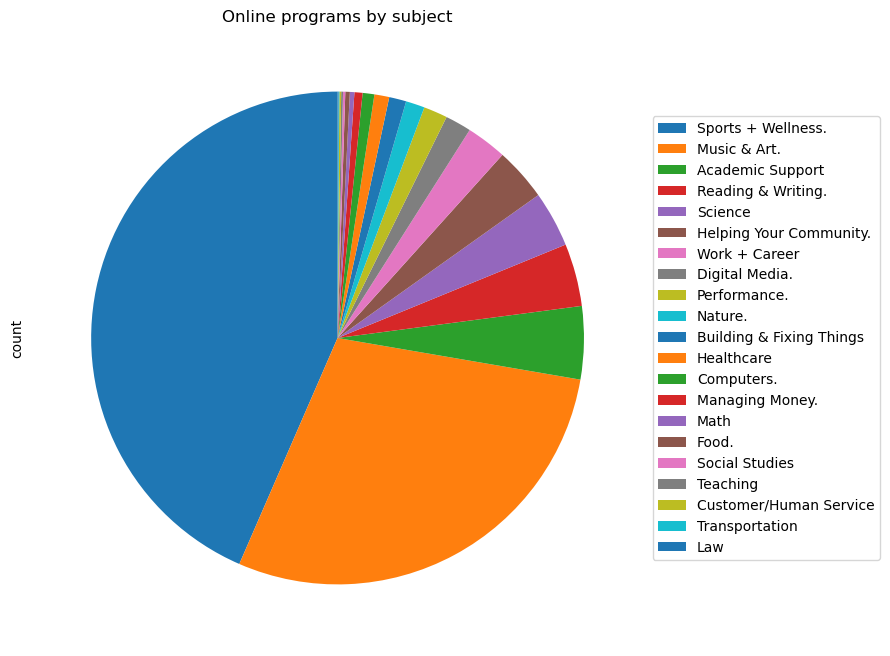

In [3]:
# online longer-term programs pie chart
subject_counts_op.plot.pie(legend = True, figsize = (8, 8), labels = None, startangle = 90)
plt.legend(subject_counts_op.index, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Online programs by subject')

Text(0.5, 0, 'Num Online Events')

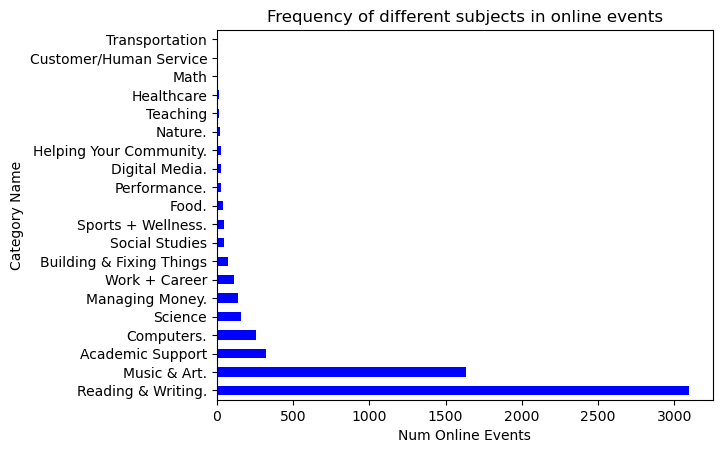

In [4]:
# online one-time events
subject_counts_oe = online_events['Category Name'].value_counts()
subject_counts_oe.plot(kind = 'barh', color = 'blue')
plt.title('Frequency of different subjects in online events')
plt.xlabel('Num Online Events')

Text(0.5, 1.0, 'Online events by subject')

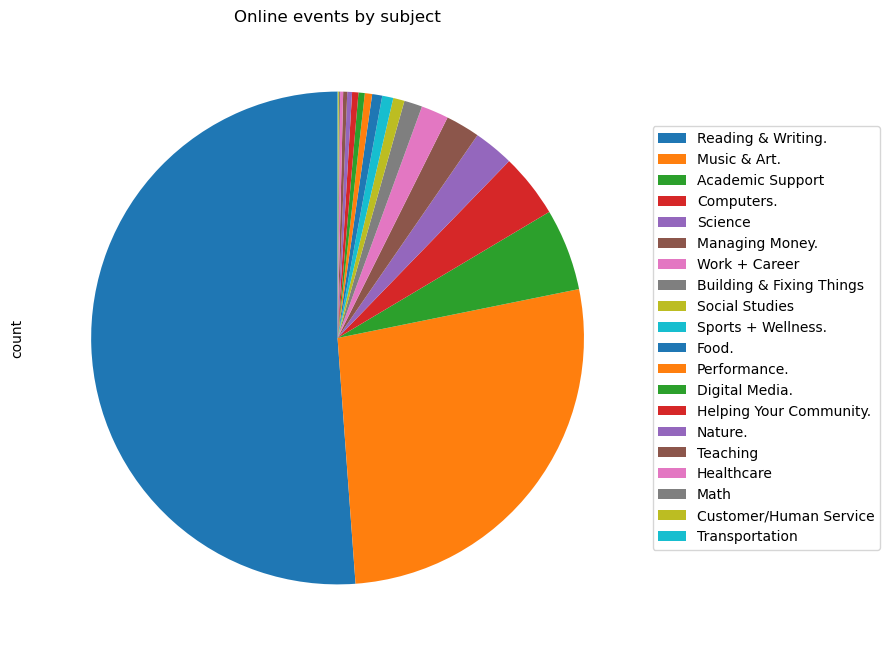

In [5]:
# online one-time events pie chart
subject_counts_oe.plot.pie(legend = True, figsize = (8, 8), labels = None, startangle = 90)
plt.legend(subject_counts_oe.index, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Online events by subject')

In [201]:
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
# preparing the Chicago Data Portal community areas dataset
boundaries = gpd.read_file('/Users/danielqian/Downloads/CommAreas_20241122.csv')
boundaries['the_geom'] = boundaries['the_geom'].apply(wkt.loads)
boundaries_gdf = gpd.GeoDataFrame(boundaries, geometry = 'the_geom')
boundaries_gdf.set_crs('EPSG:4326', inplace = True)
in_person = my_chi[my_chi['Meeting Type'] == 'face_to_face']
in_person_has_coord = in_person.dropna(subset = ['Latitude', 'Longitude'])
coords = in_person_has_coord[['Latitude', 'Longitude']]
coords['geometry'] = coords.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis = 1)
coord_gdf = gpd.GeoDataFrame(coords, geometry = 'geometry')
coord_gdf.set_crs('EPSG:4326', inplace = True)
# joining Chicago Data Portal and MyChi datasets
programs_in_communities = gpd.sjoin(coord_gdf, boundaries_gdf, how = "inner", op = 'within')
programs_with_communities = in_person_has_coord.join(programs_in_communities, lsuffix = '_df', rsuffix = '_gdf')
# dealing with programs with NAn values for the point coordinates
na = programs_with_communities[programs_with_communities['COMMUNITY'].isna()]
na['geometry_left'] = na.apply(lambda row: Point(row['Longitude_df'], row['Latitude_df']), axis = 1)
na_indices = na.index
programs_with_communities.loc[na_indices, 'geometry_left'] = na['geometry_left']
# grouping programs by communities and calculating square mileages
programs_per_area = programs_with_communities.groupby('COMMUNITY').size()
programs_with_communities['SHAPE_AREA'] = pd.to_numeric(programs_with_communities['SHAPE_AREA'])
programs_with_communities['square miles'] = programs_with_communities['SHAPE_AREA'] / 27878400

/var/folders/b9/3w4_njfn4518gvt404c4tcz00000gn/T/ipykernel_89431/2329548439.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords['geometry'] = coords.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis = 1)
/Users/danielqian/anaconda3/envs/stat303_conda_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/b9/3w4_njfn4518gvt404c4tcz00000gn/T/ipykernel_89431/2329548439.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Text(0.5, 1.0, 'Bottom 15 and top 5 communities in academic support programming per sq mi')

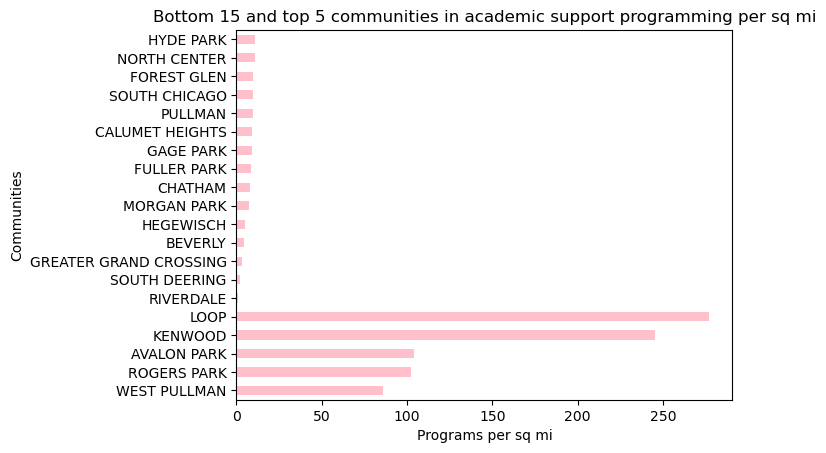

In [202]:
# academic support programs per square mile bar chart
academic_support = programs_with_communities[programs_with_communities['Category Name'] == 'Academic Support']
support_by_comm = academic_support.groupby('COMMUNITY').size().reset_index(name = 'program_count')
academic_support = academic_support.merge(support_by_comm, on = 'COMMUNITY', how = 'left')
support_per_sq_mi = academic_support['program_count'] / academic_support['square miles']
sorted_per = support_per_sq_mi.drop_duplicates().sort_values()
sorted_per_best_5 = sorted_per[-6:-1]
sorted_per_worst_15 = sorted_per[:15]
best_and_worst = pd.concat([sorted_per_best_5, sorted_per_worst_15])
indices = best_and_worst.index
df_slice = academic_support.iloc[indices]
comparison_plot = best_and_worst.plot(kind = 'barh', color = 'pink')
comparison_plot.set_yticklabels(df_slice['COMMUNITY'])
plt.ylabel('Communities')
plt.xlabel('Programs per sq mi')
plt.title('Bottom 15 and top 5 communities in academic support programming per sq mi')


Text(0.5, 1.0, 'Bottom 15 and top 5 communities in reading & writing programming per sq mi')

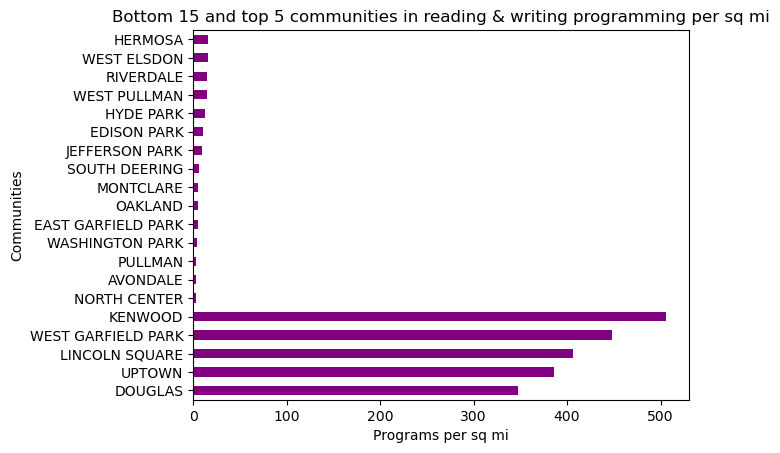

In [203]:
# reading and writing programs per square mile bar chart
reading = programs_with_communities[programs_with_communities['Category Name'] == 'Reading & Writing.']
reading_by_comm = reading.groupby('COMMUNITY').size().reset_index(name = 'program_count')
reading = reading.merge(reading_by_comm, on = 'COMMUNITY', how = 'left')
reading_per_sq_mi = reading['program_count'] / reading['square miles']
sorted_per_reading = reading_per_sq_mi.drop_duplicates().sort_values()
sorted_per_best_reading = sorted_per_reading[-6:-1]
sorted_per_worst_reading = sorted_per_reading[:15]
best_and_worst_reading = pd.concat([sorted_per_best_reading, sorted_per_worst_reading])
indices_reading = best_and_worst_reading.index
df_slice_reading = reading.iloc[indices_reading]
comparison_plot_reading = best_and_worst_reading.plot(kind = 'barh', color = 'purple')
comparison_plot_reading.set_yticklabels(df_slice_reading['COMMUNITY'])
plt.ylabel('Communities')
plt.xlabel('Programs per sq mi')
plt.title('Bottom 15 and top 5 communities in reading & writing programming per sq mi')


Text(0.5, 1.0, 'Bottom 15 and top 5 communities in art & music programming per sq mi')

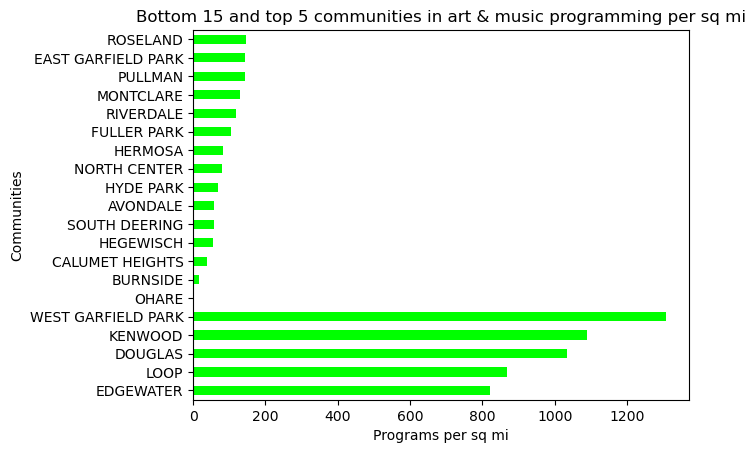

In [204]:
# music and art programs per square mile bar chart
music = programs_with_communities[programs_with_communities['Category Name'] == 'Music & Art.']
music_by_comm = music.groupby('COMMUNITY').size().reset_index(name = 'program_count')
music = music.merge(music_by_comm, on = 'COMMUNITY', how = 'left')
music_per_sq_mi = music['program_count'] / music['square miles']
sorted_per_music = music_per_sq_mi.drop_duplicates().sort_values()
sorted_per_best_music = sorted_per_music[-6:-1]
sorted_per_worst_music = sorted_per_music[:15]
best_and_worst_music = pd.concat([sorted_per_best_music, sorted_per_worst_music])
indices_music = best_and_worst_music.index
df_slice_music = music.iloc[indices_music]
comparison_plot_music = best_and_worst_music.plot(kind = 'barh', color = 'lime')
comparison_plot_music.set_yticklabels(df_slice_music['COMMUNITY'])
plt.ylabel('Communities')
plt.xlabel('Programs per sq mi')
plt.title('Bottom 15 and top 5 communities in art & music programming per sq mi')
